## Assigment 3
## XuanHui Li 18044666

<span style="font-size: 90%;">
Introduction: This project mainly involves building a machine learning model based on macroeconomic indicators (such as OCR, CPI, GDP, etc.) to predict the quarterly increase in house prices in New Zealand.
<br><br>
Data source: RBNZ (New Zealand Reserve Bank), Stats NZ (New Zealand Bureau of Statistics), and REINZ (HPI data).
<br><br>
Based on the model development of my notebook: I used XGBoost with lagging and rolling operations, including optimization, and also created a Catboost and a random forest model to compare the root mean square error of the models, including hyperparameter tuning.
</span>

## EDA for data set


Based on Zhang Yue's combined data, I utilized the combined data for Exploratory Data Analysis (EDA).

First, I loaded the "Clean_house" data as a combined dataset and then observed the first few rows. I found that there was no OCR (Official Cash Rate) before 2000, which would cause data alignment issues. Therefore, I conducted a filter to remove the data before 2000 to ensure the data was reasonable. 

And I found that some of the data are sorted by "year/month/day", while others are sorted by "day/month/year". So I standardized the date format.

At the same time, I inserted a time series graph and a correlation heatmap, including the calculation of the percentage of HPI to visualize. It was observed that OCR has a negative correlation with the growth of house prices, and there is also the importance of House_sales
, etc.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from catboost import CatBoostRegressor

In [11]:
#---Read data set ---
df_final =df_final = pd.read_csv(r'C:\Users\Playtech\Desktop\Ass3\clean_house.csv')
print(df_final.head())

      quarter  year  house_sales    hpi  house_stock  residential_investment  \
0  1990-03-31  1990      22855.0  477.0     123000.0                    1790   
1  1990-06-30  1990      22684.0  480.0     125000.0                    2043   
2  1990-09-30  1990      20176.0  483.0     126000.0                    1873   
3  1990-12-31  1990      17480.0  482.0     126000.0                    1985   
4  1991-03-31  1991      17338.0  479.0     124000.0                    1567   

   ocr     cpi    gdp  
0  NaN  573.78  18300  
1  NaN  583.79  18329  
2  NaN  589.18  18816  
3  NaN  595.34  20461  
4  NaN  599.89  17864  


In [13]:
# 1. Convert the 'quarter' column to a standard datetime format
df_final['quarter'] = pd.to_datetime(df_final['quarter'])
# 2. Set the 'quarter' column as the index of the data frame
df_final.set_index('quarter', inplace=True)
# 3. Delete the redundant 'year' column
df_final.drop(columns=['year'], inplace=True)
# 4. Filtering can now be performed on the correct date index.
df_final_filtered = df_final[df_final.index >= '2000-03-31'].copy()
print(df_final_filtered.head())
df_final_filtered.info()

            house_sales    hpi  house_stock  residential_investment   ocr  \
quarter                                                                     
2000-03-31      22912.0  705.0     229000.0                    2706  5.31   
2000-06-30      19752.0  698.0     229000.0                    2298  6.21   
2000-09-30      18464.0  697.0     232000.0                    2386  6.50   
2000-12-31      18382.0  697.0     232000.0                    2099  6.50   
2001-03-31      22747.0  701.0     236000.0                    1848  6.45   

              cpi    gdp  
quarter                   
2000-03-31  688.0  27457  
2000-06-30  693.0  28068  
2000-09-30  701.0  28800  
2000-12-31  709.0  31429  
2001-03-31  709.0  27979  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102 entries, 2000-03-31 to 2025-06-30
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   house_sales             101 non-null 

## calculate hpi precentage and Visualization 

C:\Users\Playtech\AppData\Local\Temp\ipykernel_31476\4143478017.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_final_filtered['hpi_growth'] = df_final_filtered['hpi'].pct_change() * 100


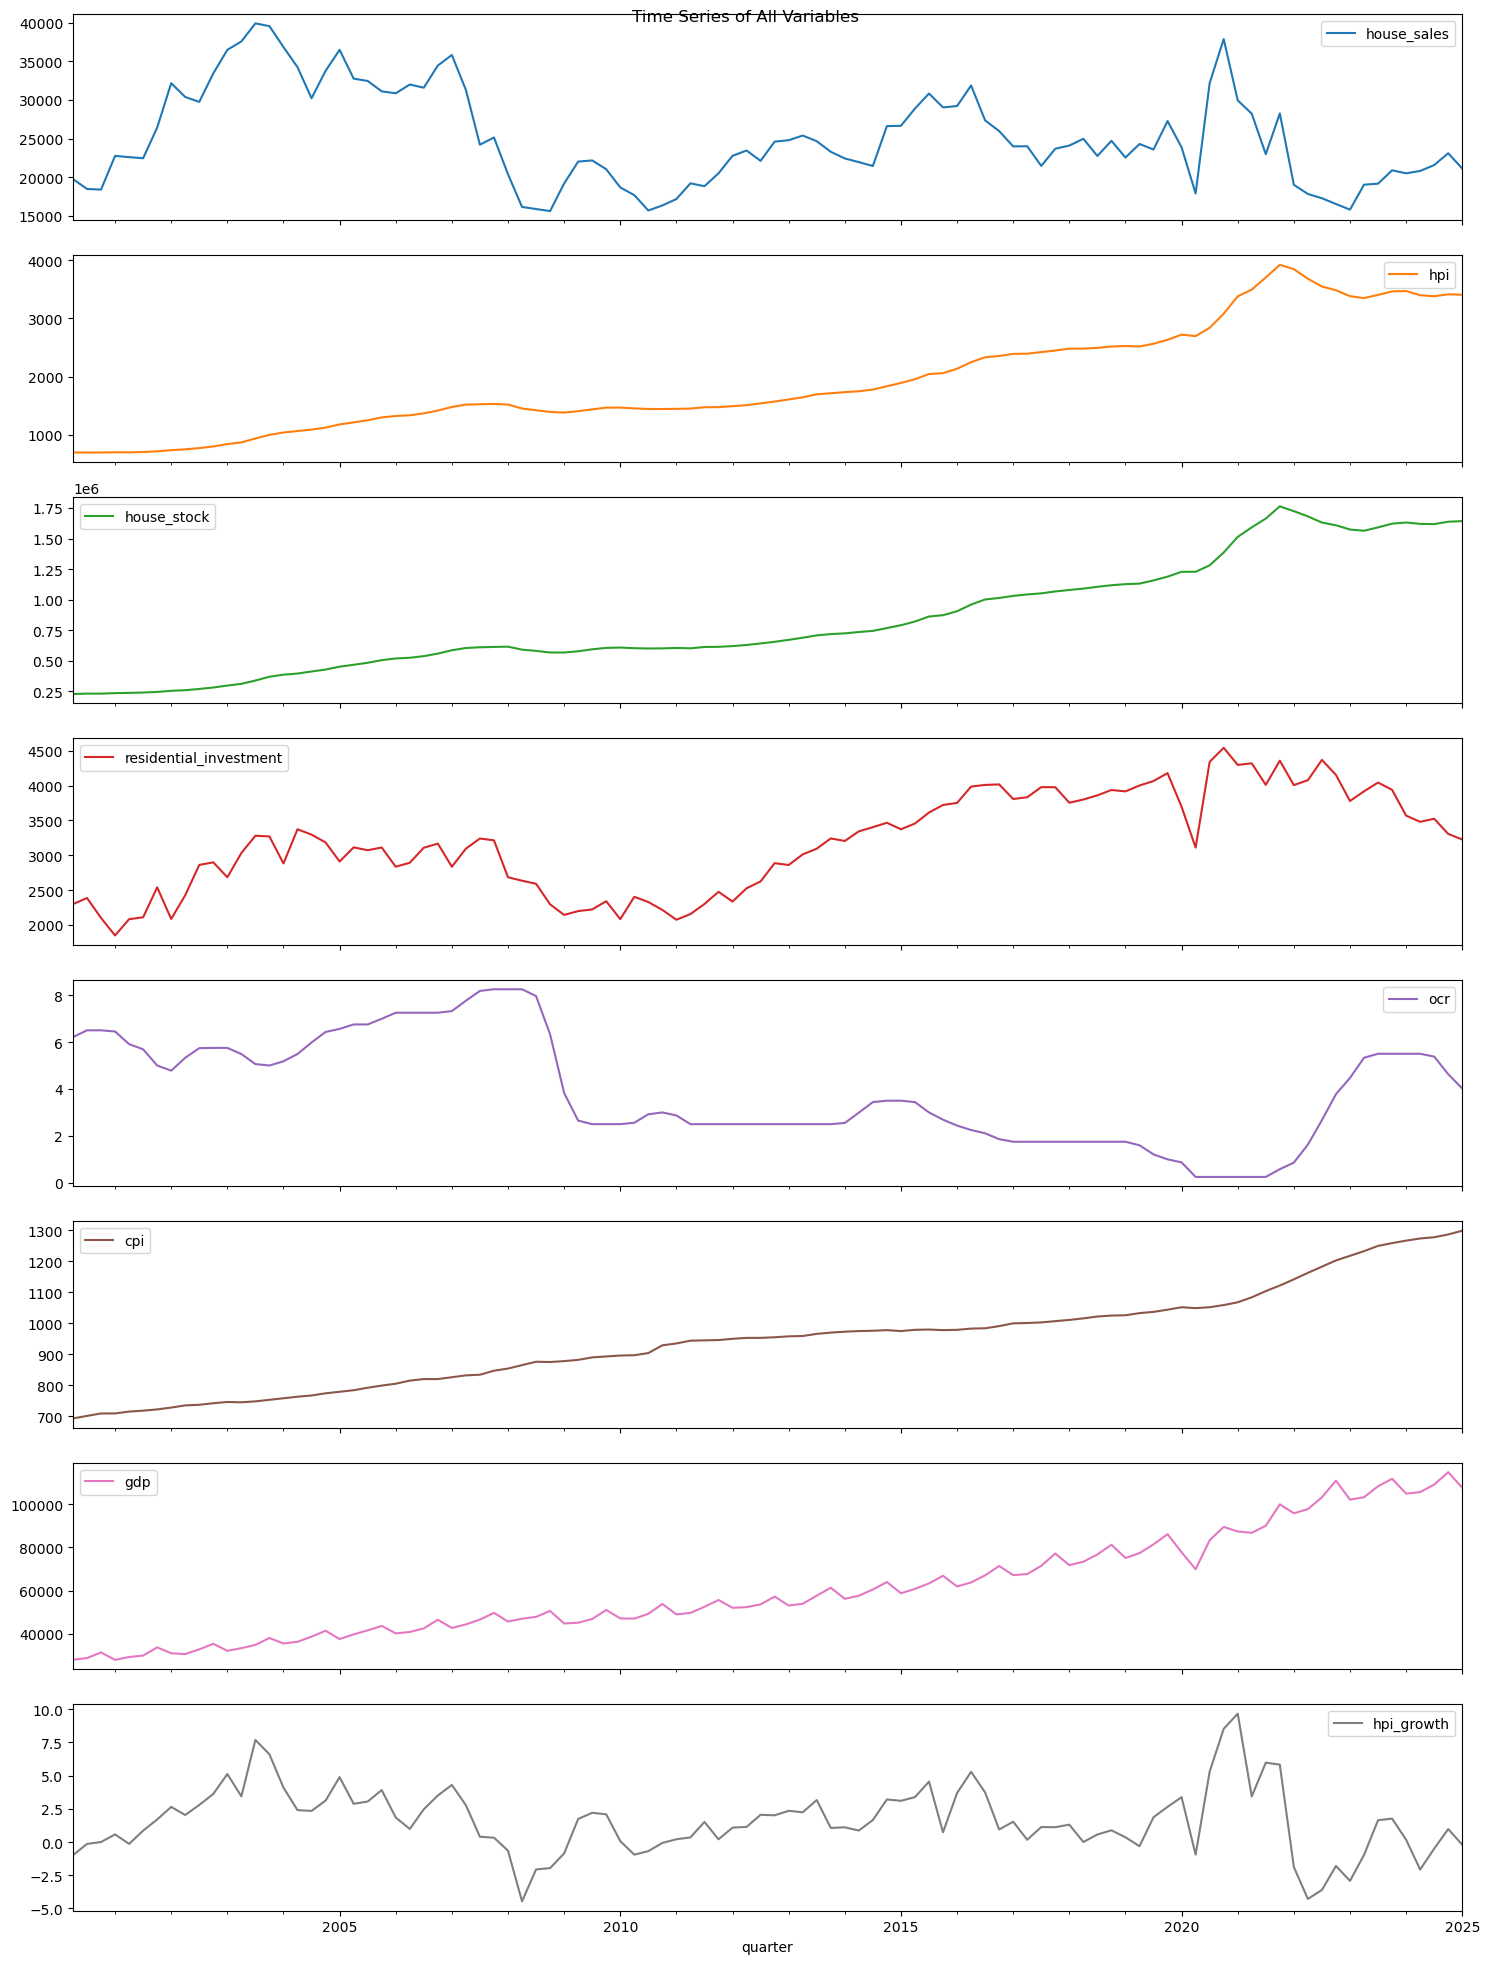

In [15]:
df_final_filtered['hpi_growth'] = df_final_filtered['hpi'].pct_change() * 100
df_final_filtered.dropna(inplace=True)
df_final_filtered.plot(subplots=True, layout=(-1, 1), figsize=(15, 20), title='Time Series of All Variables')
plt.tight_layout()
plt.show()

Overall, these charts tell a classic economic story: In the context of economic growth (GDP increase) and inflation (CPI increase).
When the interest rate (OCR) is low, the real estate market (hpi_growth) becomes active and grows; when the interest rate is raised to curb inflation, the real estate market cools down rapidly.

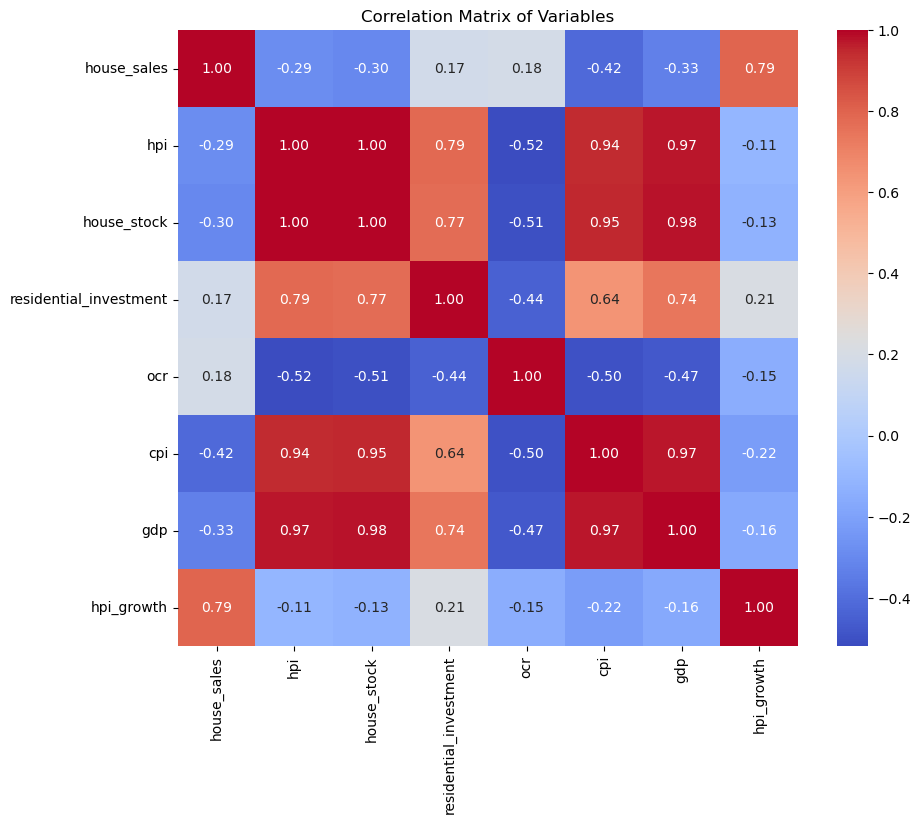

In [49]:
# --- heat map ---
correlation_matrix = df_final_filtered.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Variables')
plt.show()

## Feature Engineer

Before training the XGboost model, I created lag features and rolling features. These new features help the model capture the dynamics and trends of the market.

In [19]:
# --- preocess lag ---
for lag in range(1, 5):
    # Lagged Target Variable
    df_final_filtered[f'hpi_growth_lag_{lag}'] = df_final_filtered['hpi_growth'].shift(lag)
    
    # Lagged Core Predictors
    df_final_filtered[f'ocr_lag_{lag}'] = df_final_filtered['ocr'].shift(lag)
    df_final_filtered[f'gdp_lag_{lag}'] = df_final_filtered['gdp'].shift(lag)
    df_final_filtered[f'cpi_lag_{lag}'] = df_final_filtered['cpi'].shift(lag)
    df_final_filtered[f'house_sales_lag_{lag}'] = df_final_filtered['house_sales'].shift(lag)
# --- (Rolling Features) ---
rolling_window = 4
df_final_filtered['ocr_roll_avg_4q'] = df_final_filtered['ocr'].rolling(window=rolling_window).mean()
df_final_filtered['gdp_roll_avg_4q'] = df_final_filtered['gdp'].rolling(window=rolling_window).mean()
df_final_filtered['cpi_roll_avg_4q'] = df_final_filtered['cpi'].rolling(window=rolling_window).mean()

# --- Remove NaN values generated due to the creation of lag/rolling features ---
df_engineered = df_final_filtered.dropna()
print(df_engineered.head())

            house_sales    hpi  house_stock  residential_investment   ocr  \
quarter                                                                     
2001-06-30      22587.0  700.0     238000.0                    2082  5.91   
2001-09-30      22444.0  706.0     241000.0                    2109  5.69   
2001-12-31      26415.0  718.0     246000.0                    2539  5.00   
2002-03-31      32158.0  737.0     255000.0                    2085  4.78   
2002-06-30      30378.0  752.0     260000.0                    2426  5.33   

              cpi    gdp  hpi_growth  hpi_growth_lag_1  ocr_lag_1  ...  \
quarter                                                            ...   
2001-06-30  715.0  29293   -0.142653          0.573888       6.45  ...   
2001-09-30  718.0  29960    0.857143         -0.142653       5.91  ...   
2001-12-31  722.0  33759    1.699717          0.857143       5.69  ...   
2002-03-31  728.0  31030    2.646240          1.699717       5.00  ...   
2002-06-30  735.

In [21]:
print(f"The number of rows in the original data frame: {len(df_final_filtered)}")
print(f"The number of rows in the engineered data frame: {len(df_engineered)}")
print([col for col in df_engineered.columns if '_lag_' in col or '_roll_' in col][:5]) 

The number of rows in the original data frame: 100
The number of rows in the engineered data frame: 96
['hpi_growth_lag_1', 'ocr_lag_1', 'gdp_lag_1', 'cpi_lag_1', 'house_sales_lag_1']


## model training (XGboost)

Before building the XGboost model, I used the period up to December 31, 2022 as the sub-training set, while the period after that was the test set. Then I created an XGboost model without hyperparameter tuning. Its error value was 3.4132, indicating that the model's accuracy was relatively low.

In [27]:
# --- Define the features (X) and the target (y) ---
# y is the target variable
y = df_engineered['hpi_growth']
# X represents all the columns except for the target variable and the original hpi.
X = df_engineered.drop(columns=['hpi_growth', 'hpi'])
# --- Divide the training set and test set (by time) ---
# Use the data up to the end of 2022 as the training set, and the data after that as the test set
split_date = '2022-12-31'

X_train = X[X.index <= split_date]
y_train = y[y.index <= split_date]

X_test = X[X.index > split_date]
y_test = y[y.index > split_date]

print(f"Size of the training set: {len(X_train)} record")
print(f"Size of the test set: {len(X_test)} record")

Size of the training set: 87 record
Size of the training set: 9 record


In [31]:
# --- Initialize and train the XGBoost model ---
# Start by using some common default parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=100,          
    learning_rate=0.1,         
    objective='reg:squarederror', 
    random_state=42            
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [33]:
# --- Model Evaluation ---
# --- Use the trained xgb_model to make predictions on the test set (X_test) ---
predictions = xgb_model.predict(X_test)
# --- Use Root Mean Square Error (RMSE) as the evaluation metric ---
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f"The predictive performance of the model (RMSE): {rmse:.4f}")

The predictive performance of the model (RMSE): 3.4132


C:\Users\Playtech\anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


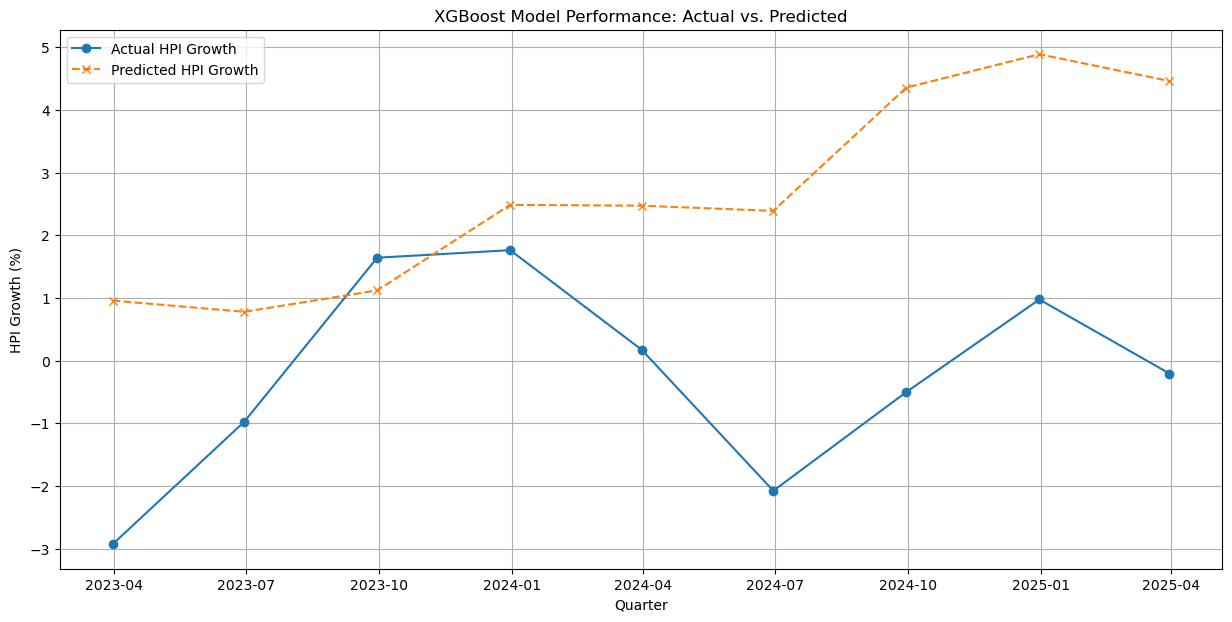

In [35]:
# --- Visualization ---
results_df = pd.DataFrame({
    'Actual_Growth': y_test,
    'Predicted_Growth': predictions
}, index=y_test.index)


plt.figure(figsize=(15, 7))
plt.plot(results_df['Actual_Growth'], label='Actual HPI Growth', marker='o')
plt.plot(results_df['Predicted_Growth'], label='Predicted HPI Growth', linestyle='--', marker='x')
plt.title('XGBoost Model Performance: Actual vs. Predicted')
plt.xlabel('Quarter')
plt.ylabel('HPI Growth (%)')
plt.legend()
plt.grid(True)
plt.show()

The blue line represents the actual value of HPI growth, while the yellow dotted line shows the predicted value. From the visualization, it can be observed that there is a significant downward trend in July 2024.

## Hyperparameter tuning

Subsequently, I conducted hyperparameter tuning for XGboost. Initially, I employed GridSearch and TimeSeriesSplit to identify the optimal parameters for the model.

At the same time, I also used Skit Learn to fit the Catboost model and the random forest model. Then, I simultaneously conducted hyperparameter tuning. Finally, I compared the models and found that the error value of XGboost was actually not lower than that of the Catboost and random forest models. (In fact, it is the highest.)

Among these three models, the Catboost model has the lowest error value.

In [38]:
# 1. Define the parameter grid to be tested
#    Here, three key parameters are selected for optimization:
#    n_estimators: The number of trees
#    learning_rate: The learning rate
#    max_depth: The maximum depth of each tree
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
# --- Create a base model, and GridSearchCV will use it to test different parameters ---
base_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
# --- Set up time series cross-validation ---
# --- n_splits = 5 (Create 5 consecutive training/evaluation data folds) ---
tscv = TimeSeriesSplit(n_splits=5)
# --- Initialize and run GridSearchCV ---
#    The parameter 'scoring='neg_root_mean_squared_error'' indicates that the objective is to minimize the RMSE
#    Setting 'n_jobs=-1' will utilize all available CPU cores to accelerate the calculation
#    With 'verbose=2', the search process will be printed out
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=2
)
# --- Run the search on the training data ---
grid_search.fit(X_train, y_train)
print(f"The optimal combination of parameters that was found is: {grid_search.best_params_}")
print(f"The corresponding optimal RMSE score is: {-grid_search.best_score_:.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
The optimal combination of parameters that was found is: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
The corresponding optimal RMSE score is: 2.2154


In [44]:
# -- Obtain the best parameters found from the completed grid_search ---
best_params = grid_search.best_params_
print(f"Use the best parameters that have been found: {best_params}")
# --- Create and train the final model using the optimal parameters ---
final_tuned_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params  
)
final_tuned_model.fit(X_train, y_train)

使用找到的最佳参数: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [46]:
# --- Evaluate the tuned model on the test set ---
# 1. Use the final_tuned_model that has been tuned to make predictions on the test set (X_test)
final_predictions = final_tuned_model.predict(X_test)
# 2. Evaluate the performance of the new model on the test set
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(f"The final performance of the optimized model on the test set: {final_rmse:.4f}")

The final performance of the optimized model on the test set: 1.9950


C:\Users\Playtech\anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


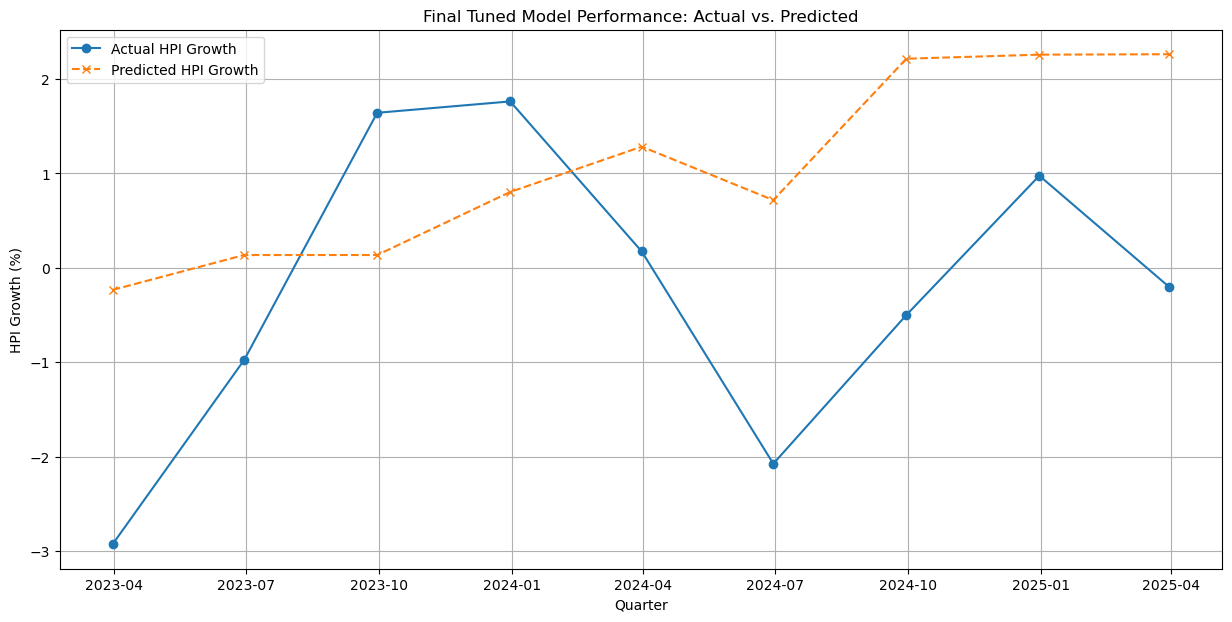

In [48]:
# --- Visualize the final predicted results vs. the actual values ---
final_results_df = pd.DataFrame({
    'Actual_Growth': y_test,
    'Predicted_Growth_Tuned': final_predictions
}, index=y_test.index)

plt.figure(figsize=(15, 7))
plt.plot(final_results_df['Actual_Growth'], label='Actual HPI Growth', marker='o')
plt.plot(final_results_df['Predicted_Growth_Tuned'], label='Predicted HPI Growth', linestyle='--', marker='x')

plt.title('Final Tuned Model Performance: Actual vs. Predicted')
plt.xlabel('Quarter')
plt.ylabel('HPI Growth (%)')
plt.legend()
plt.grid(True)
plt.show()

## Train a CatBoost

In [50]:
# --- Training and tuning CatBoost ---
# --- Define the parameter grid for CatBoost ---
#    iterations is similar to n_estimators
#    depth is similar to max_depth
catboost_param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.05, 0.1],
    'depth': [3, 5, 7]
}
# --- Initialize the basic CatBoost model ---
catboost_base = CatBoostRegressor(random_state=42, verbose=0) # verbose=0 Avoid printing excessive logs during the search process
# --- We continue to use the previously defined time series cross-validation tscv ---
tscv = TimeSeriesSplit(n_splits=5)
# --- Initialize and run GridSearchCV ---
catboost_grid_search = GridSearchCV(
    estimator=catboost_base,
    param_grid=catboost_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=2
)
catboost_grid_search.fit(X_train, y_train)
print(f"\nCatBoost The best parameters found: {catboost_grid_search.best_params_}")
final_catboost_model = CatBoostRegressor(random_state=42, verbose=0, **catboost_grid_search.best_params_)
final_catboost_model.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits

CatBoost 找到的最佳参数: {'depth': 3, 'iterations': 100, 'learning_rate': 0.05}


In [53]:
# --- Evaluate the final CatBoost model on the test set ---
catboost_predictions = final_catboost_model.predict(X_test)
catboost_rmse = mean_squared_error(y_test, catboost_predictions, squared=False)
print(f"\n--- The final performance (RMSE) of the CatBoost model after optimization on the [test set]: {catboost_rmse:.4f} ---")


--- The final performance (RMSE) of the CatBoost model after optimization on the [test set]: 1.3495 ---


C:\Users\Playtech\anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## RandomForest Model

In [92]:
# --- Training and Tuning of the Random Forest Model ---
from sklearn.ensemble import RandomForestRegressor
# --- Define the parameter grid for Random Forest ---
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, None], # "None" indicates no limit on the depth.
    'max_features': ['sqrt', 'log2']
}
# --- Initialize the basic model of Random Forest ---
rf_base = RandomForestRegressor(random_state=42)
# 3. Initialize and run GridSearchCV
rf_grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=2
)
rf_grid_search.fit(X_train, y_train)
# 5. Print the optimal parameters and create, train the final Random Forest model
print(f"\nRandom Forest the best parameters found: {rf_grid_search.best_params_}")
final_rf_model = RandomForestRegressor(random_state=42, **rf_grid_search.best_params_)
final_rf_model.fit(X_train, y_train)
# 6. Evaluate the final Random Forest model on the test set
rf_predictions = final_rf_model.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
print(f"\n--- The final performance (RMSE) of the tuned Random Forest model on the [test set]: {rf_rmse:.4f} ---")

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Random Forest the best parameters found: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}

--- The final performance (RMSE) of the tuned Random Forest model on the [test set]: 1.6249 ---


C:\Users\Playtech\anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Visualization of Model Performance Comparison

C:\Users\Playtech\AppData\Local\Temp\ipykernel_8188\3488955513.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Test RMSE', data=performance_df, palette='viridis')


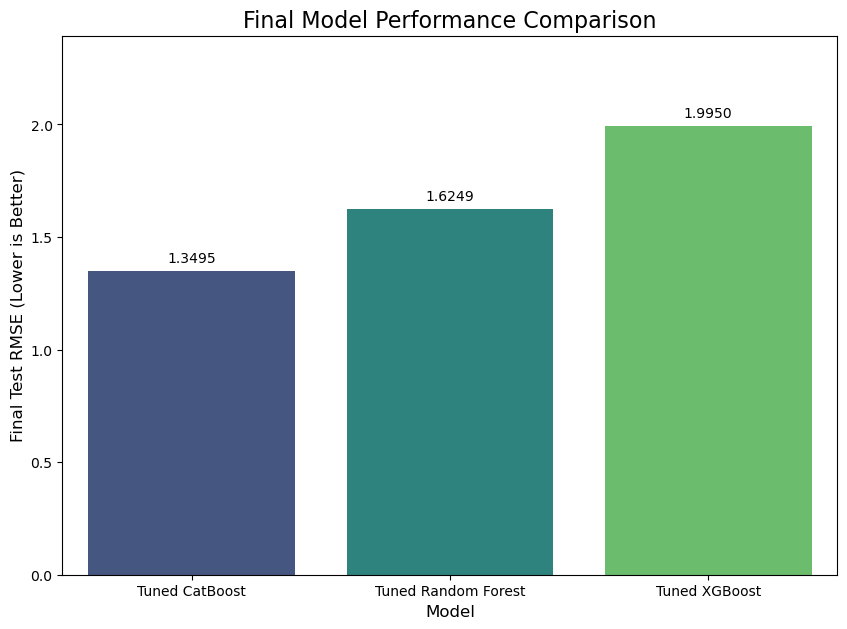

In [87]:
xgb_rmse = 1.9950
catboost_rmse = 1.3495
rf_rmse = 1.6249
model_performance = {
    'Model': ['Tuned XGBoost', 'Tuned CatBoost', 'Tuned Random Forest'],
    'Test RMSE': [xgb_rmse, catboost_rmse, rf_rmse]
}

performance_df = pd.DataFrame(model_performance)
# --- Sorted by RMSE to display the performance levels in the chart ---
performance_df = performance_df.sort_values(by='Test RMSE', ascending=True)
# --- Visualization ---
plt.figure(figsize=(10, 7))
ax = sns.barplot(x='Model', y='Test RMSE', data=performance_df, palette='viridis')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title('Final Model Performance Comparison', fontsize=16)
plt.ylabel('Final Test RMSE (Lower is Better)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, max(performance_df['Test RMSE']) * 1.2) 
plt.show()

## XAI

From the summary graph of XAI, it can be seen which features have the greatest overall influence on the model's prediction results among all the test samples.

The most important feature of the model is the number of house sales. Both high sales volume (represented by red dots) and low sales volume (represented by blue dots) tend to have negative SHAP values.

The relationship between the housing price increases in the previous quarter is very clear. The high quarter-on-quarter growth rate (the red dot) generated a positive SHAP value (boosting the prediction), while the low quarter-on-quarter growth rate (the blue dot) produced a negative SHAP value (lowering the prediction). This indicates that the model successfully captured the market trend. 
The rolling average of GDP over the past year shows a strong growth momentum (indicated by the red dot), but it has a negative SHAP value (lowering the prediction), which may reflect the pattern learned by the model: periods of overheating in the economy tend to lead to subsequent policy tightening (such as raising interest rates), thereby curbing housing price growth. 
The lagging component of CPI also demonstrated a similar influence as that of GDP, further reducing the model's prediction of housing price growth.

Therefore, the visualization graph shows that the model not only depends on direct market behaviors (such as sales volume and historical growth rates), but also reveals how macroeconomic indicators predict future market trends. House sales and hpi_growth_lag_1 are the strongest drivers for short-term predictions.

In [64]:
import shap
# 1. Initialize the SHAP interpreter
#    We use TreeExplainer because it has been optimized for the tree models we are using (such as CatBoost, XGBoost)
explainer = shap.TreeExplainer(final_catboost_model)

# 2. Calculate the SHAP values for the test set (X_test)
#    This will calculate a contribution value for each data point and each feature in the test set
shap_values = explainer.shap_values(X_test)

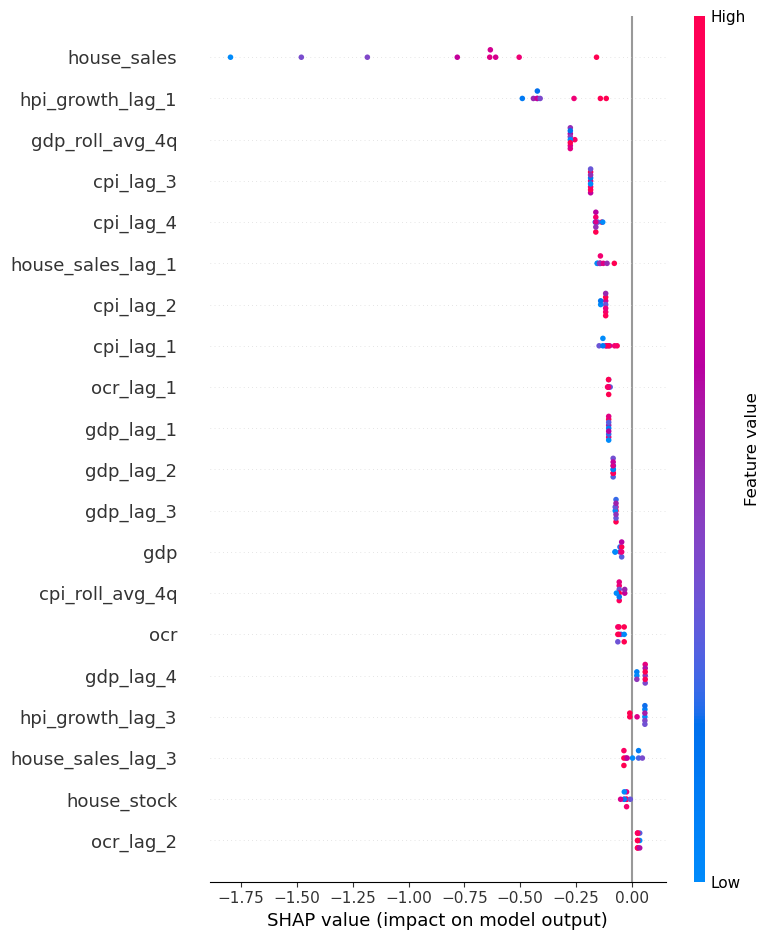

In [66]:
#--- Summary Plot ---
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Waterfall Plot 

This waterfall chart explains why the model ultimately predicted a -1.808% negative growth for the first sample in the test set.

We can see from the bottom right corner of the visualization graph, E[f(x)] = 1.876, which represents the average value of all the predictions made by the model. That is to say, without any specific information, the model "by default" predicts a growth of approximately +1.88%.

The most significant negative factor is that house_sales = 15786. This indicates that this quantity is a relatively low value for the model, thus lowering the baseline of the prediction result by 1.8 percentage points.

This also indicates that, in that particular quarter, although the macroeconomic environment seemed favorable and suggested that house prices should rise, the dismal housing sales data and the previous downward trend were so strong that they completely overwhelmed all the positive signals, ultimately leading the model to conclude a negative growth.

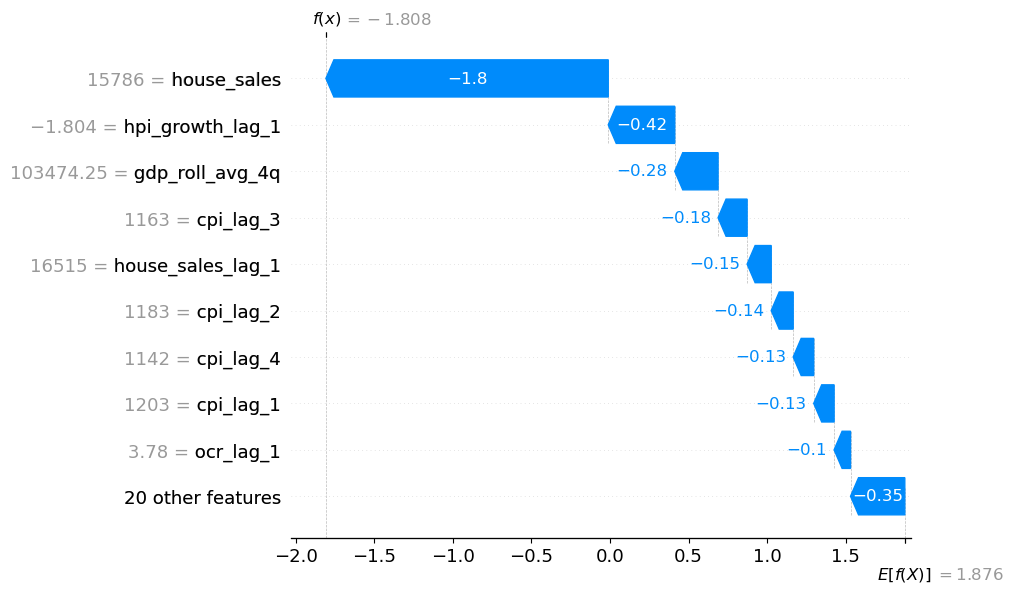

In [68]:
# --- Waterfall Plot ---
# Create Waterfall Plot
# We need to create an Explanation object to contain all the necessary information
shap_explanation = shap.Explanation(
    values=shap_values[0], 
    base_values=explainer.expected_value, 
    data=X_test.iloc[0], 
    feature_names=X_test.columns
)

shap.plots.waterfall(shap_explanation)

### Conclusion

This project aims to build a machine learning model that can accurately predict the quarterly increase in house prices by integrating key macroeconomic indicators from New Zealand (such as the Official Cash Rate, Consumer Price Index, and GDP) and market behavior data (such as the number of house sales).

After a series of rigorous experiments, we conducted feature engineering, hyperparameter tuning, and performance evaluation on three of the industry's leading tree models: XGBoost, CatBoost, and Random Forest. fianl, **The tuned CatBoost model performed the best.**，On the test set, the root mean square error (RMSE) achieved was **1.3495**, which was significantly better than that of other models. This indicates that the model successfully learned the complex economic dynamics and possesses reliable predictive capabilities.

By applying the SHAP (SHapley Additive exPlanations) explainable artificial intelligence (XAI) technology to conduct a thorough analysis of the best model, we have gained profound insights into the key factors influencing the increase in house prices and their relationships:

1.  **The internal momentum of the market is the core driving force for short-term predictions**：
    * The analysis clearly indicates,**`house_sales` (Number of house sales)** 和 **`hpi_growth_lag_1` (The increase in housing prices in the previous quarter)** These are the two most important predictive features of the model. This indicates that the intrinsic "trend" of the market - namely, the recent trading activity and the price change trend - are the most direct and powerful signals determining the direction of housing prices in the next quarter.

2.  **The lagging and reverse-indicating effects of macroeconomic indicators**：
    * `gdp_roll_avg_4q` (GDP rolling average) and `cpi_lag` (CPI lag term) When the indicators show a negative correlation with the increase in housing prices.This may seem counterintuitive, but the analysis of XAI reveals the underlying economic logic that the model has learned:**An overheated macroeconomic environment (with high GDP growth and high inflation) often indicates possible future policy tightening (such as raising interest rates), thereby exerting an inhibitory effect on the expected growth of house prices in advance.**This demonstrates that the model does not merely rely on surface-level data; rather, it is learning how the market responds to changes in the macro environment.**Expected reaction**。
    * `ocr_lag_1` The impact of the (official cash rate of the previous quarter) is in complete accordance with traditional economic theory, which states that high interest rates curb housing price growth while low interest rates boost it.

3.  **Complex trade-offs involving multiple factors**：
    * The case of the partial explanation of the waterfall chart vividly demonstrates how the model weighs different and even contradictory signals in each specific prediction. For instance, even when macroeconomic indicators are generally positive, a weak housing sales figure is sufficient for the model to ultimately predict a negative growth.

The analysis indicates that the increase in house prices in New Zealand is a complex system driven by both the short-term momentum within the market and the response to the macroeconomic environment. Among these, the recent transaction volume and price changes are the most crucial direct indicators for short-term predictions, while macroeconomic data such as GDP and inflation provide valuable leading signals for predicting market turning points.